In [311]:
import sys
sys.path.insert(0, '..')

In [312]:
import optimistix as optx


In [313]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)


# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *
from spectra import *

import jax.tree_util as jtu

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [314]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [315]:
wid = 80
oversample = 4

nwavels = 5#13#6
npoly=3#10#2

n_zernikes = 20#12

optics = NICMOSOptics(1024, wid, oversample, n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"

# brown dwarf

files = [
    #'n8yj53vfq_cal.fits',
    #'n8yj53vkq_cal.fits',
    'n8yj02x0q_cal.fits',
    #'n8yj02wyq_cal.fits'

]

files = [
    #'n8yj63wmq_cal.fits',
    #'n8yj63woq_cal.fits',
    #"n8yj63wlq_cal.fits",
    "n8yj63wnq_cal.fits"
]

"""

# lhs 1846
ddir = "../data/MAST_2025-03-02T22_29_29.259Z/HST/"

files = ["n8ku01ffq_cal.fits", "n8ku01fgq_cal.fits"][:1]

ddir = "../data/MAST_2024-09-08T07_59_18.213Z/HST/"

files = [
    # F095N
    "n43ca5fjq_cal.fits",
    "n43ca5fkq_cal.fits",
    "n43ca5flq_cal.fits",
    "n43ca5fmq_cal.fits",
    #F190N
    "n43ca5feq_cal.fits",
    "n43ca5ffq_cal.fits",
    "n43ca5fgq_cal.fits",
    "n43ca5fhq_cal.fits",
    #F187N
    #"n43c03dnq_cal.fits",
    #"n43c03doq_cal.fits",
    #"n43c03dpq_cal.fits",
    #"n43c03drq_cal.fits",
    #F108N
    #"n43c03dsq_cal.fits",
    #"n43c03duq_cal.fits",
    ##"n43c03dvq_cal.fits",
    ##"n43c03dwq_cal.fits",
][-1:]

# hyades

ddir = "../data/MAST_2024-09-26T22_53_13.719Z/HST/"

files = [
    "n8ry37p8q_cal.fits",
    "n8ry37p9q_cal.fits",

    #"n8ry13mqq_cal.fits",
    #"n8ry13mrq_cal.fits"
][:-1]


ddir = '../data/MAST_2025-03-06T11_35_52.340Z/HST/'

files = [
    #F110M
    'n4be02npq_cal.fits',
    'n4be02nsq_cal.fits',
    'n4be02nvq_cal.fits',
    'n4be02nyq_cal.fits',

    #F145M
    'n4be02nqq_cal.fits',
    'n4be02ntq_cal.fits',
    'n4be02nwq_cal.fits',
    'n4be02o0q_cal.fits',
]#[:1]#[-2:-1]
"""

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)

#exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_single = [exposure_from_file(ddir + file, SinglePointFit(CombinedFourierSpectrum, nwavels), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

files = [
    #'n8yj63wmq_cal.fits',
    #'n8yj63woq_cal.fits',
    #"n8yj63wlq_cal.fits",
    "n8yj63wnq_cal.fits"
]


#exposures_single = [
#    exposure_from_file(ddir + "n8yj63wnq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 5), crop=wid),
#    exposure_from_file(ddir + "n8yj63wmq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 15), crop=wid),
#    ]

files = [
    #'n8yj53vfq_cal.fits',
    #'n8yj53vkq_cal.fits',
    'n8yj02x0q_cal.fits',
    #'n8yj02wyq_cal.fits'

]
exposures_single = [
    #exposure_from_file(ddir + "n8yj02wxq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 5), crop=wid),
    exposure_from_file(ddir + "n8yj02wzq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 5), crop=wid),
    exposure_from_file(ddir + "n8yj02x0q_cal.fits", SinglePointFit(CombinedFourierSpectrum, 15), crop=wid),
    #exposure_from_file(ddir + "n8yj02wyq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 15), crop=wid),
    ]


/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_34996/3336588115.py:124: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposure_from_file(ddir + "n8yj02wzq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 5), crop=wid),
/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_34996/3336588115.py:125: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposure_from_file(ddir + "n8yj02x0q_cal.fits", SinglePointFit(CombinedFourierSpectrum, 15), crop=wid),


In [316]:
for e in exposures_single:
    print(e.mjd)#*86400)
    print(e.target)
    print(e.filter)

53433.77215622
U11296
F170M
53433.77760762
U11296
F110W


In [317]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.043142,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

positions = [[0.,0.,],[0.,0.,],[0.,0.,],[0.,0.,]]#[[0.43251792, 0.33013815],[ 0.49417186, -0.5629123 ]]

positions_dict = {'n8yj02wxq': np.asarray([-0.24098018,  0.5766413 ]), 'n8yj02wyq': np.asarray([-0.2771823 ,  0.45730695]), 'n8yj02wzq': np.asarray([-0.6211268 , -0.68924445]), 'n8yj02x0q': np.asarray([ 0.45046756, -0.8387074 ])}
nspec = [3, 10, 10]#[3, 10]
nw = [5, 15, 15]#[5, 15]

for idx, exp in enumerate(exposures_single):
    params["positions"][exp.fit.get_key(exp, "positions")] = positions_dict[exp.fit.get_key(exp, "positions")]#np.asarray(positions[idx])#np.asarray([0.49162114, -0.5632928])#np.asarray([ 0.45184505, -0.8391668 ])#np.asarray([-0.2,0.4])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(nspec[idx]).at[0].set(1)*np.log10(np.nansum(exp.data)/nw[idx])#np.ones(npoly)*np.log10(np.nansum(exp.data)/nwavels)#(np.zeros(npoly)).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)#np.asarray([0., 24.884588  , -25.489779  , -17.15699   , -21.790146  ,
    #      -4.592212  ,  -4.832893  ,  19.196083  ,   0.37983412,
    #       7.0756216 ,   0.30277824,  -6.330534])#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8.,8.])#np.asarray([9.599048, 6.196583])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [318]:
print(params.params)

{'positions': {'n8yj02wzq': Array([-0.6211268 , -0.68924445], dtype=float32), 'n8yj02x0q': Array([ 0.45046756, -0.8387074 ], dtype=float32)}, 'spectrum': {'U11296_F170M': Array([3.0385885, 0.       , 0.       ], dtype=float32), 'U11296_F110W': Array([2.5634212, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ], dtype=float32)}, 'aberrations': {'global': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)}, 'cold_mask_shift': {'53434': Array([8., 8.], dtype=float32)}, 'cold_mask_rot': {'global': -45.0}, 'cold_mask_scale': {'F170M': Array([1., 1.], dtype=float32), 'F110W': Array([1., 1.], dtype=float32)}, 'cold_mask_shear': {'F170M': Array([0., 0.], dtype=float32), 'F110W': Array([0., 0.], dtype=float32)}, 'primary_scale': {'F170M': Array([1., 1.], dtype=float32), 'F110W': Array([1., 1.], dtype=float32)}, 'primary_rot': {'F170M': 45.0, 'F110W': 45.0}, 'primary_shear': {'F170M

3.869799
3.6373224


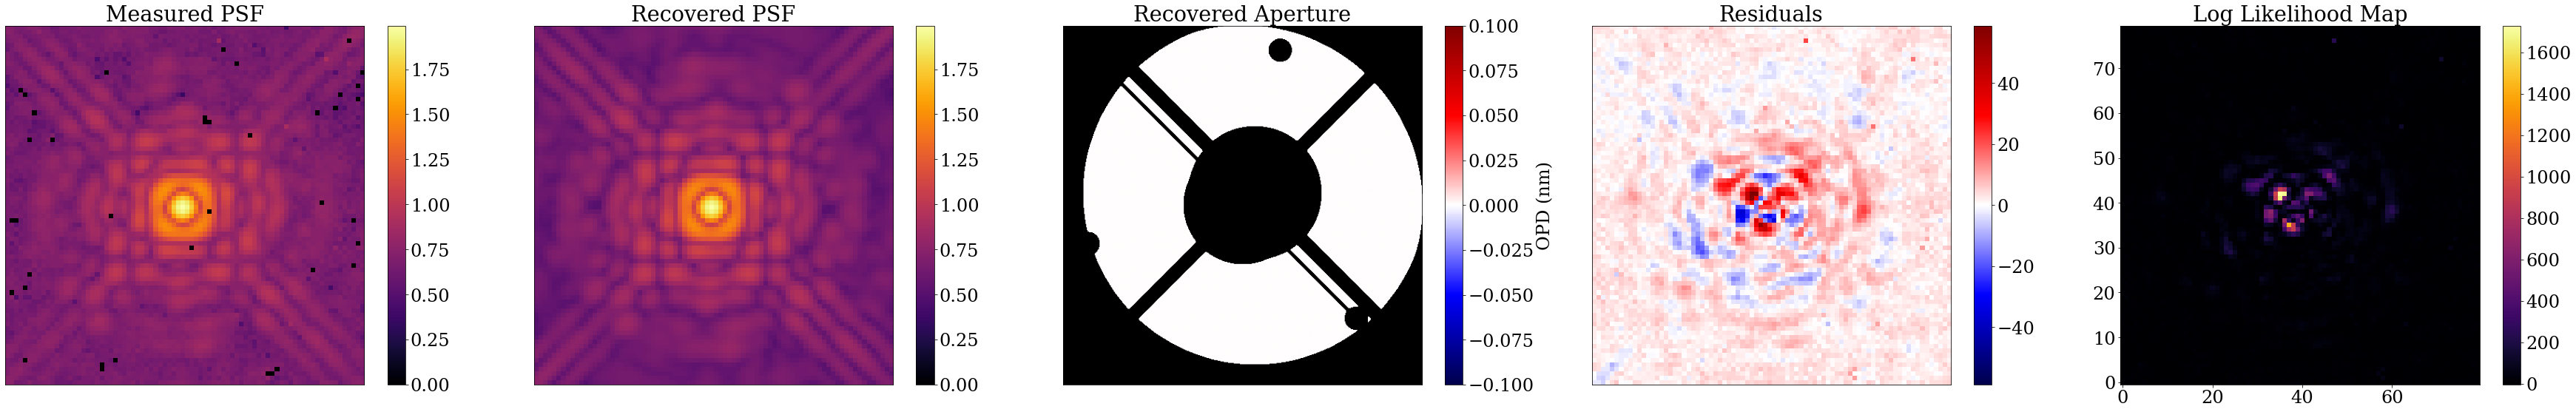

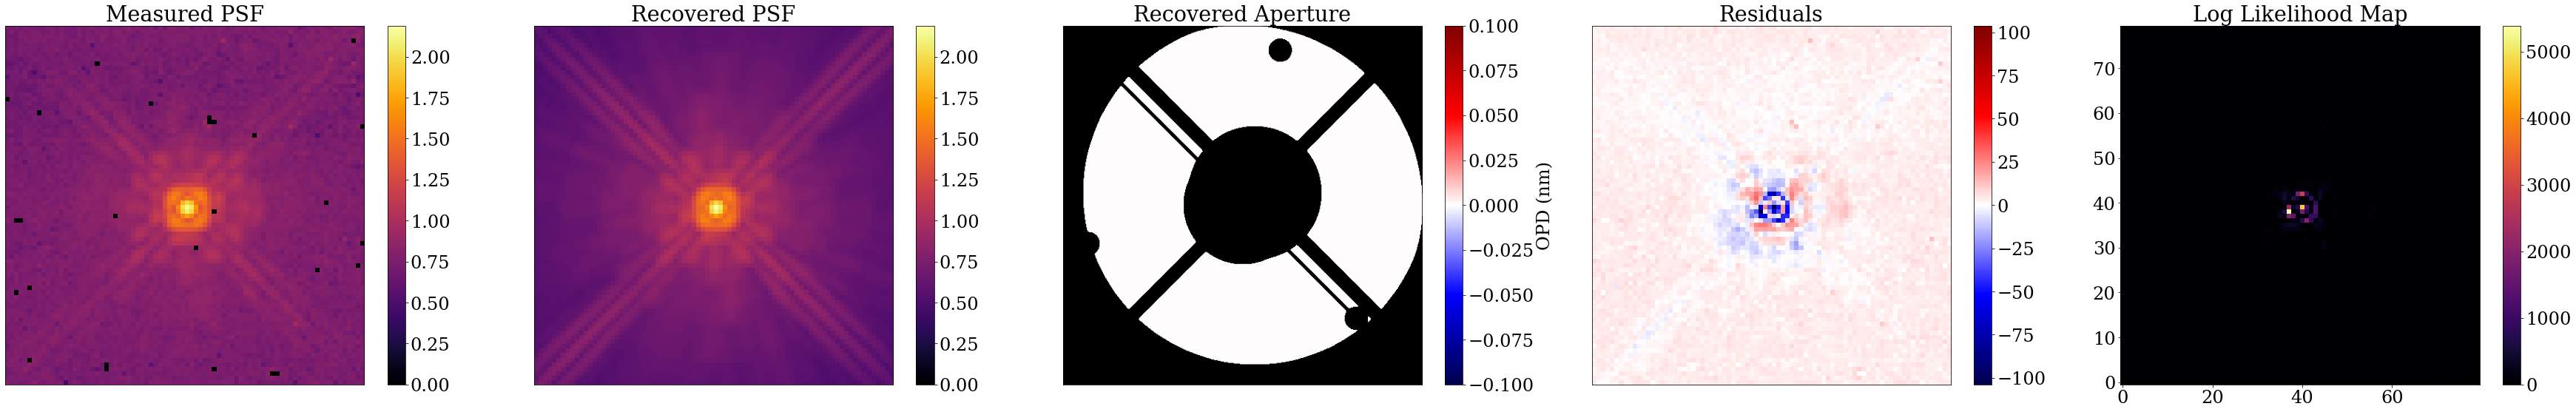

In [319]:
plot_comparison(model_single, params, exposures_single)

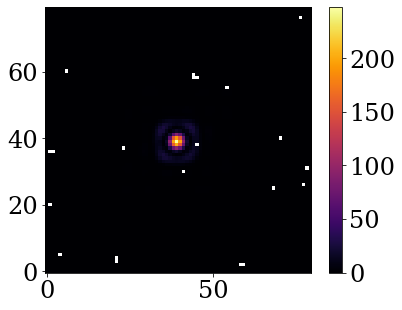

In [320]:
plt.imshow(exposures_single[0].data)
plt.colorbar()

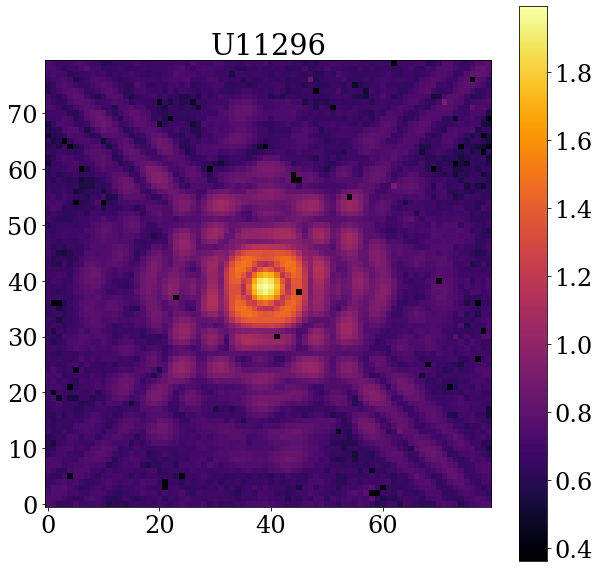

In [321]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [322]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_sgd2 = lambda vals: optax.rmsprop(vals)

opts = lambda lr, start, *schedule: base_sgd2(scheduler(lr, start, *schedule))


base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_lbfgs = lambda vals: optax.lbfgs(vals)

optl = lambda lr, start, *schedule: base_lbfgs(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*2, 10),#opt(g*2, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*10, 30),
    #"cold_mask_rot": opt(g*10, 100),
    "bias": opt(g*2, 20),
    "aberrations": opt(g*1, 50),

    #"cold_mask_scale": opt(g*1, 300),
    #"cold_mask_shear": opt(g*1, 300),
    #"primary_scale": opt(g*1, 300),
    #"primary_shear": opt(g*1, 300),
}


groups = list(things.keys())

In [323]:
losses, models = optimise(params, model_single, exposures_single, things, 200, recalculate=False)

Calculating Fishers


  0%|          | 0/2 [00:00<?, ?it/s]

Fitting Model


  0%|          | 0/200 [00:00<?, ?it/s]

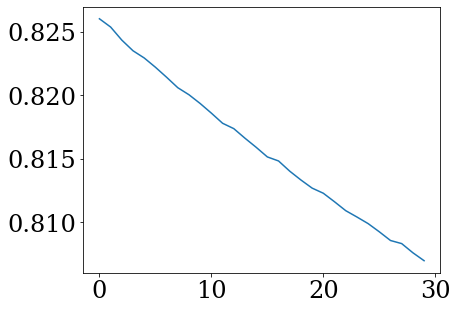

In [324]:
plt.plot(np.asarray(losses[-30:])/(len(exposures_single)*wid**2))

In [325]:
print(losses[0], losses[-1])

161596.25 10329.047


In [326]:
models_pd = [jax.tree.map(lambda x,y: (x-y)/y, models[i], models[-1]) for i in range(len(models))]

5
2.3619092
1.6245449


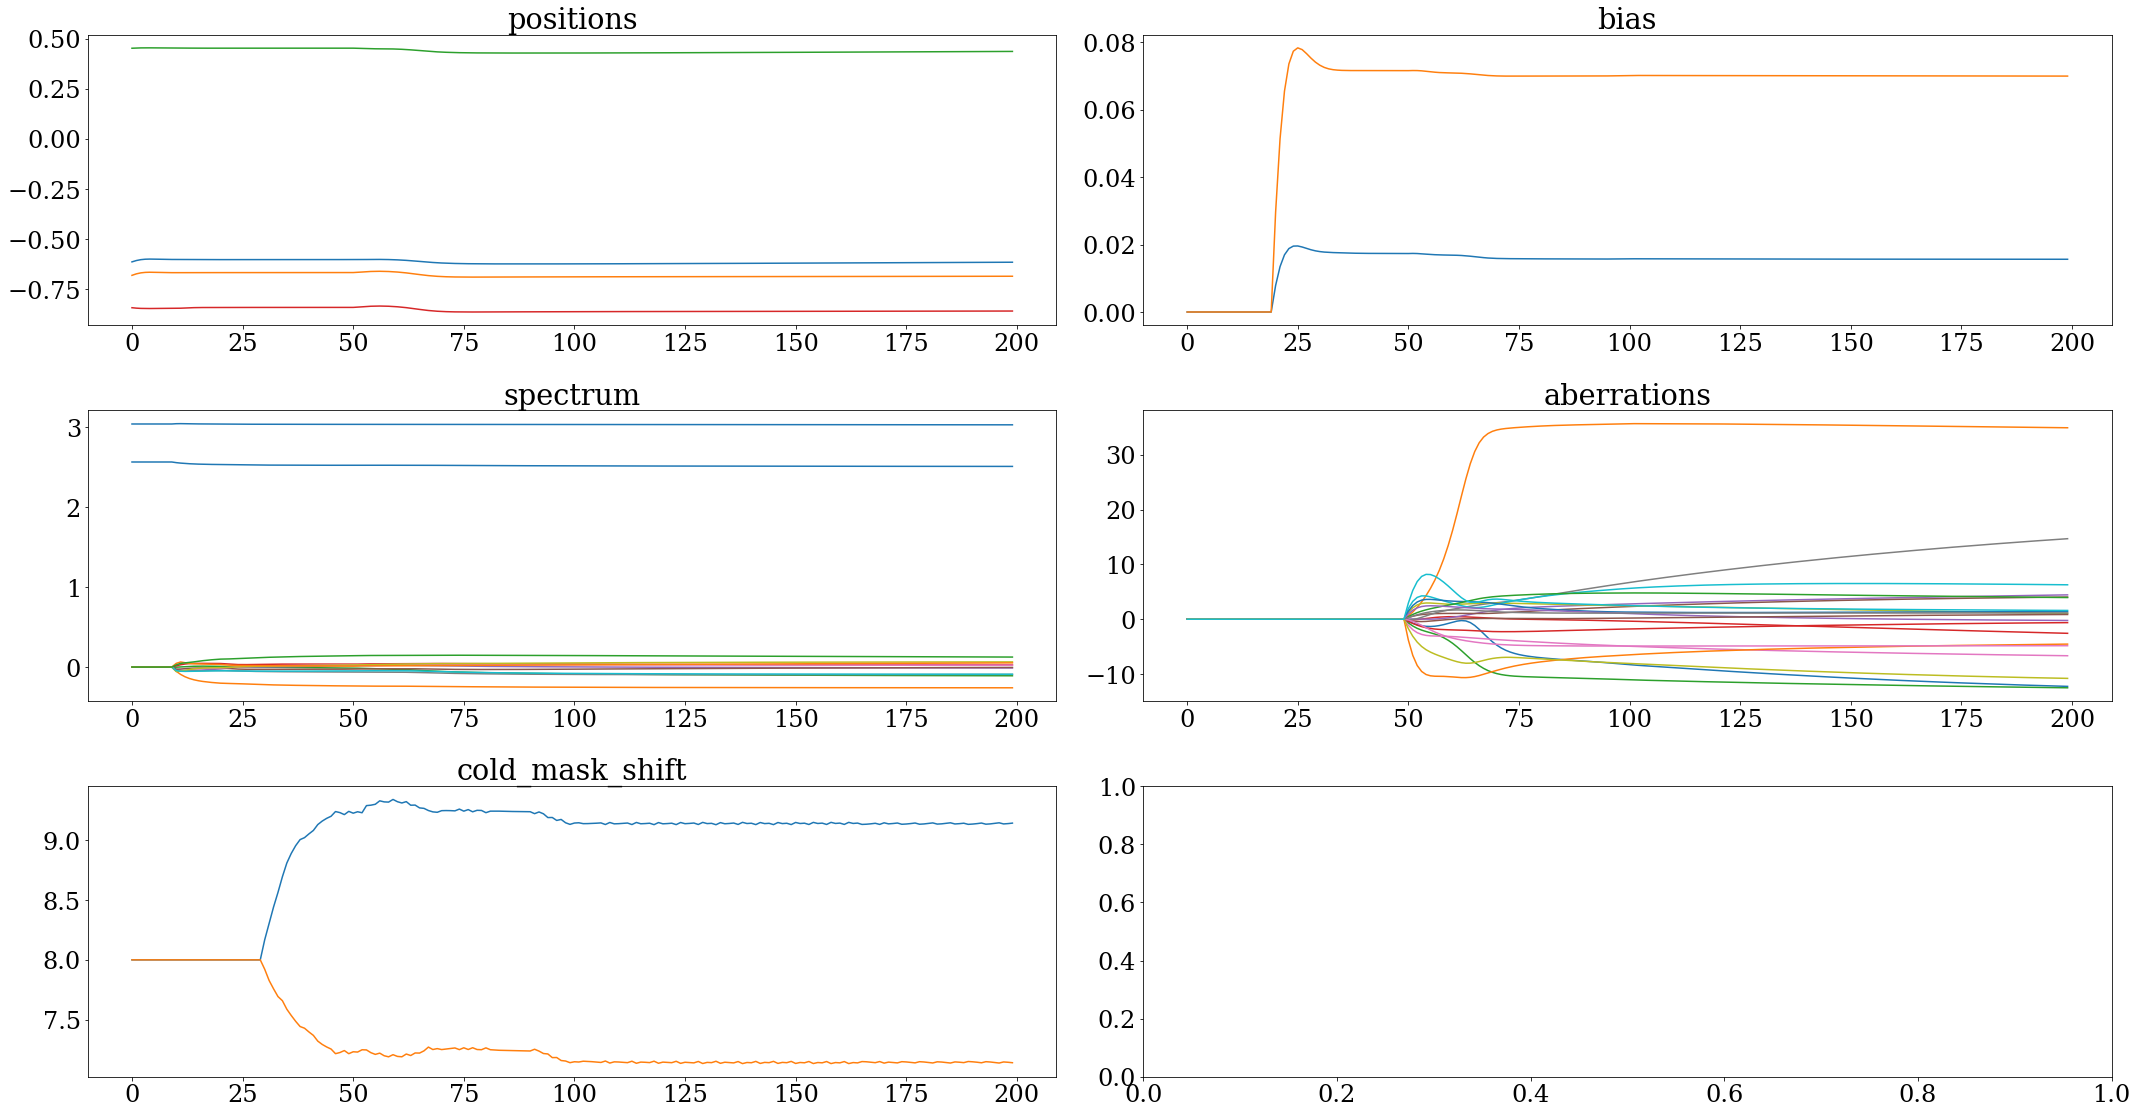

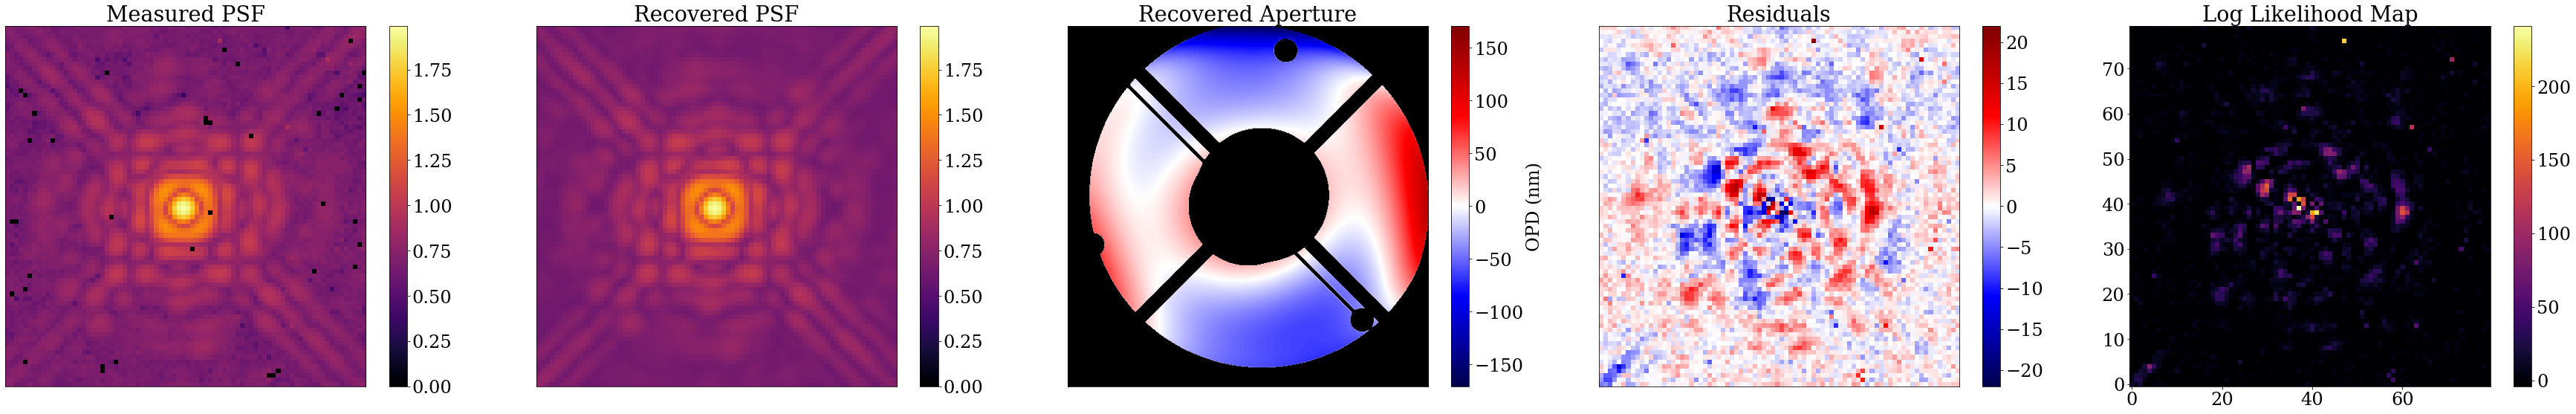

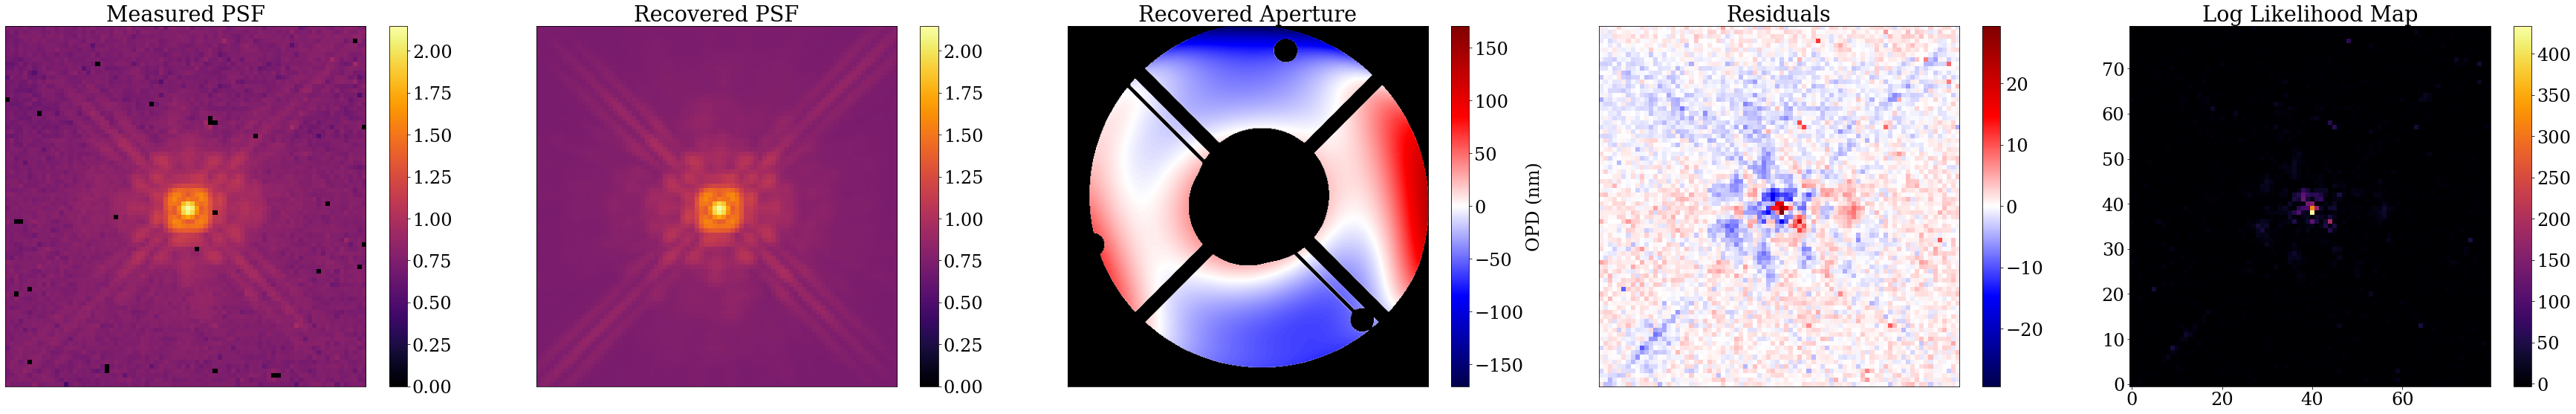

In [327]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [328]:
#stop

In [329]:
print(models[-1].params)

{'aberrations': {'global': Array([-12.264563  ,  34.954437  , -12.523912  ,  -2.5765357 ,
         4.4441586 ,   4.0495152 ,  -6.671737  ,  14.698607  ,
         1.0406535 ,   6.282843  ,   1.3886704 ,  -4.5474005 ,
         3.9563432 ,  -0.6261433 ,  -0.23194948,   0.8586653 ,
        -4.8426256 ,   1.1417545 , -10.803682  ,   1.6013229 ],      dtype=float32)}, 'bias': {'n8yj02wzq': Array(0.01564647, dtype=float32), 'n8yj02x0q': Array(0.06999747, dtype=float32)}, 'cold_mask_shift': {'53434': Array([9.143606, 7.139662], dtype=float32)}, 'positions': {'n8yj02wzq': Array([-0.61471117, -0.6846108 ], dtype=float32), 'n8yj02x0q': Array([ 0.435974  , -0.85799676], dtype=float32)}, 'spectrum': {'U11296_F110W': Array([ 2.50823   , -0.25932032, -0.10896785,  0.02689478, -0.01157766,
       -0.00479542,  0.02390755, -0.09228139,  0.06429745, -0.08974036],      dtype=float32), 'U11296_F170M': Array([3.0281775 , 0.05233525, 0.12489039], dtype=float32)}}


In [330]:
models[-1].inject(model_single)

NICMOSModel(
  params={
    'aberrations': {'global': f32[20]},
    'bias': {'n8yj02wzq': f32[], 'n8yj02x0q': f32[]},
    'cold_mask_rot': {'global': f32[]},
    'cold_mask_scale': {'F110W': f32[2], 'F170M': f32[2]},
    'cold_mask_shear': {'F110W': f32[2], 'F170M': f32[2]},
    'cold_mask_shift': {'53434': f32[2]},
    'jitter': {'n8yj02wzq': f32[], 'n8yj02x0q': f32[]},
    'outer_radius': f32[],
    'positions': {'n8yj02wzq': f32[2], 'n8yj02x0q': f32[2]},
    'primary_rot': {'F110W': f32[], 'F170M': f32[]},
    'primary_scale': {'F110W': f32[2], 'F170M': f32[2]},
    'primary_shear': {'F110W': f32[2], 'F170M': f32[2]},
    'scale': f32[],
    'secondary_radius': f32[],
    'softening': f32[],
    'spectrum': {'U11296_F110W': f32[10], 'U11296_F170M': f32[3]},
    'spider_width': f32[]
  },
  filters={'F110W': f32[240,2], 'F170M': f32[137,2]},
  optics=NICMOSOptics(
    wf_npixels=1024,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise

In [331]:
models[-1]

ModelParams(
  params={
    'aberrations': {'global': f32[20]},
    'bias': {'n8yj02wzq': f32[], 'n8yj02x0q': f32[]},
    'cold_mask_shift': {'53434': f32[2]},
    'positions': {'n8yj02wzq': f32[2], 'n8yj02x0q': f32[2]},
    'spectrum': {'U11296_F110W': f32[10], 'U11296_F170M': f32[3]}
  }
)

In [332]:
groups

['positions', 'spectrum', 'cold_mask_shift', 'bias', 'aberrations']

In [333]:
#fsh = calc_fishers(models[-1].inject(model_single), exposures_single, groups, fisher_fn, recalculate=True, save=False)


In [334]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    res = np.sum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))
    return np.where(res==0.0, np.inf, res)

@eqx.filter_jit
def fun(params, args):
    exposures, model = args
    return loss_fn(params, exposures, model)

def optimise_optimistix(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]

    model_params = ModelParams({p: params.get(p) for p in things.keys()})

    solver = optx.BFGS(rtol=1e-6, atol=1e-6,verbose=frozenset({"step_size", "loss"}))
    sol = optx.minimise(fun, solver, model_params, (exposures, model), throw=False, max_steps=niter)
    
    return sol



In [335]:
#sol = optimise_optimistix(models[-1], models[-1].inject(model_single), exposures_single, things, 5000)
#print(sol.value.params)
#print(fun(sol.value, (exposures_single, model_single)), (losses[-1]))

In [336]:
final_params = models[-1]#sol.value

In [337]:
#sol.stats

2.3619092
1.6245449


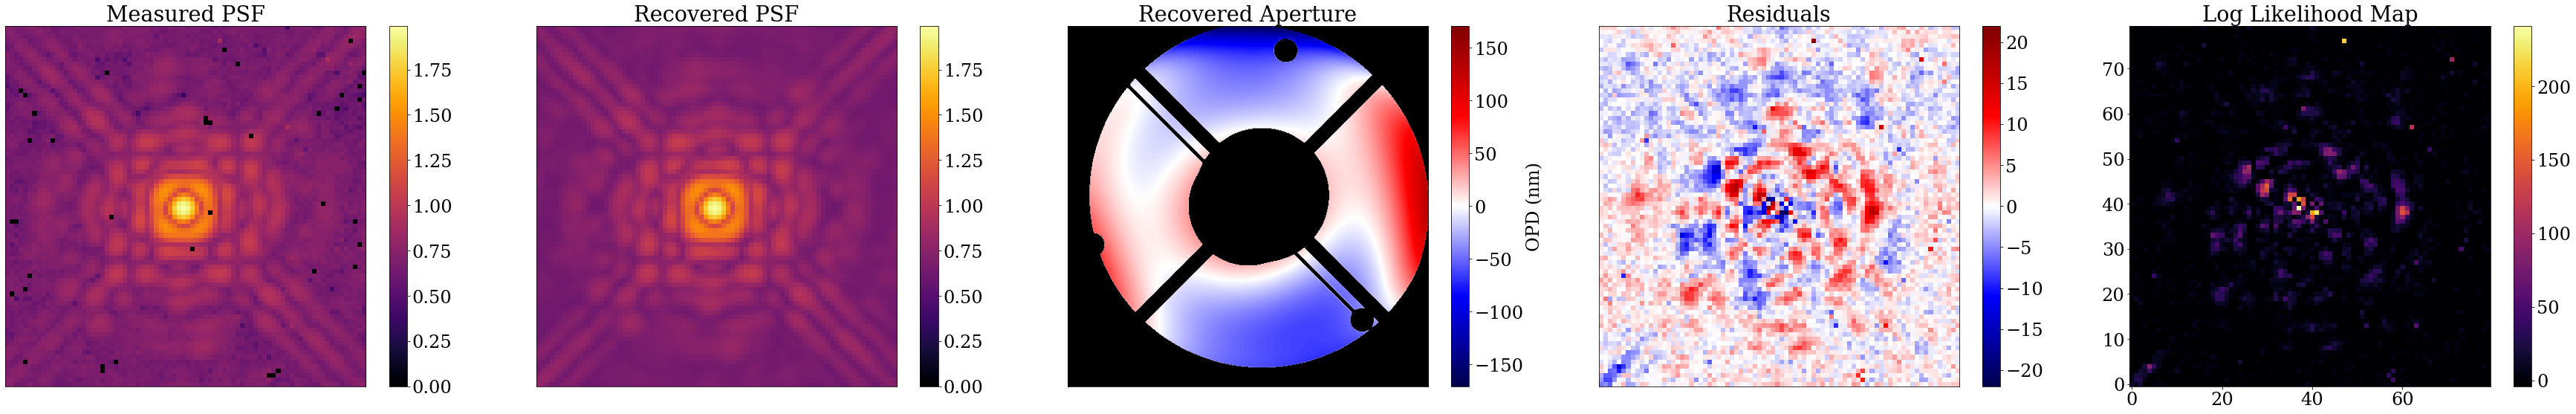

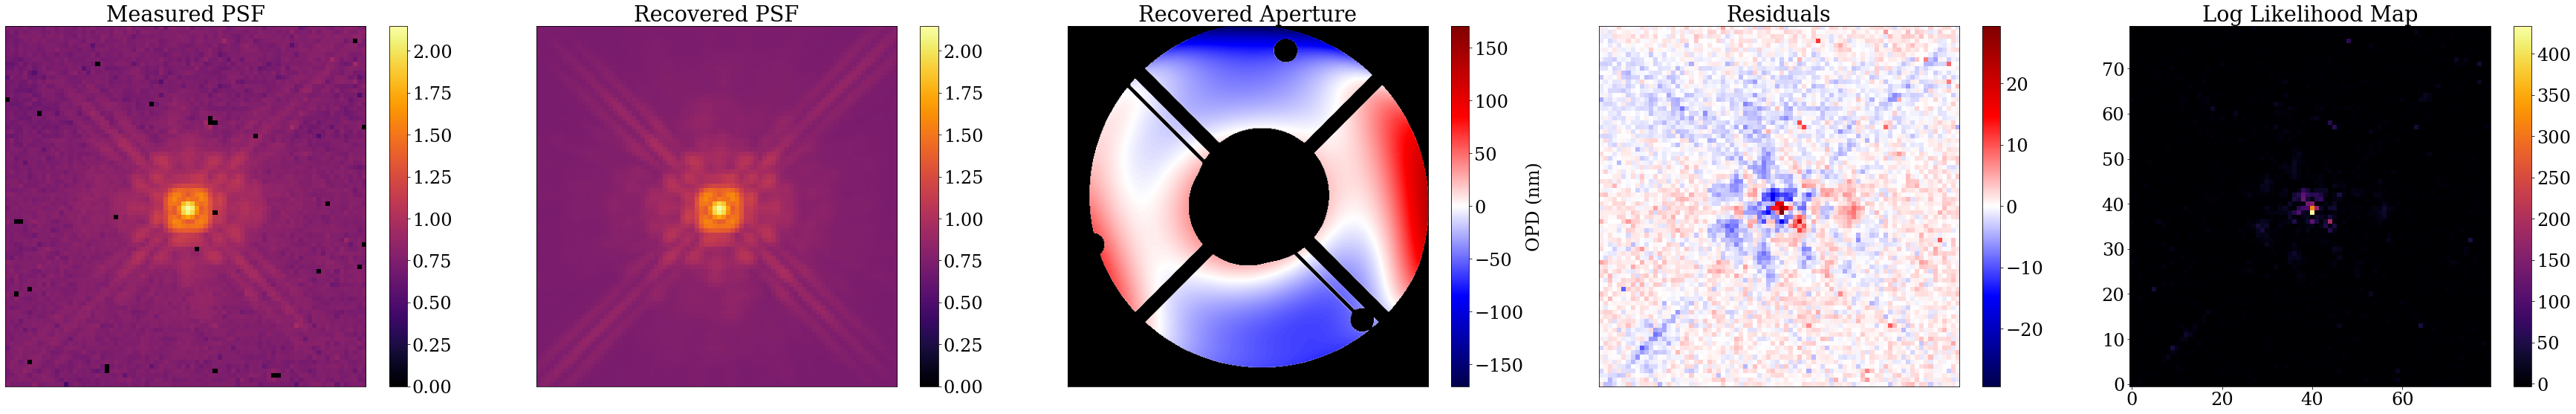

In [338]:
plot_comparison(final_params.inject(models[-1].inject(model_single)), final_params, exposures_single)

In [339]:
fsh = calc_fishers(final_params.inject(model_single), exposures_single, ["spectrum"], fisher_fn, recalculate=True, save=False)
fsh

  0%|          | 0/2 [00:00<?, ?it/s]

{'n8yj02wzq.spectrum': Array([[64476000. , 20768864. , 11064749. ],
        [20768852. ,  7181915.5,  4183449. ],
        [11064736. ,  4183450.5,  2725352.5]], dtype=float32),
 'n8yj02x0q.spectrum': Array([[ 1.86990600e+07, -3.71390750e+06, -2.69241275e+06,
          2.86563850e+06, -1.73476138e+06,  1.64302175e+06,
         -2.57994953e+05, -8.50702688e+05,  1.29423138e+06,
         -5.81078062e+05],
        [-3.71390625e+06,  1.26439100e+06,  3.34978812e+05,
         -7.86632875e+05,  5.36917250e+05, -4.03031844e+05,
          6.90339531e+04,  2.23183844e+05, -2.94900875e+05,
          1.30493672e+05],
        [-2.69241350e+06,  3.34979250e+05,  6.46762000e+05,
         -3.83276594e+05,  1.30297055e+05, -1.69230484e+05,
          2.64630254e+04,  1.14986812e+05, -1.83283312e+05,
          8.99435312e+04],
        [ 2.86563725e+06, -7.86633000e+05, -3.83276281e+05,
          6.11975188e+05, -3.58330500e+05,  2.59969656e+05,
         -3.03947969e+04, -1.68020500e+05,  2.28951156e+05,


In [340]:
spectrum_cov = np.linalg.inv(fsh['n8yj02x0q.spectrum'])#+fsh['n8yj02wyq.spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(spectrum_cov)))

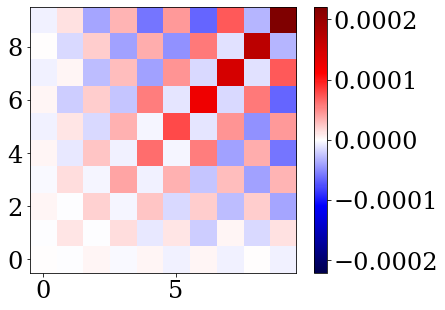

In [341]:
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()


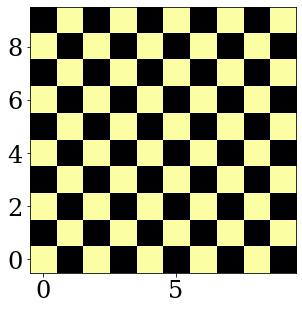

In [342]:
plt.imshow(np.sign(spectrum_cov))

In [343]:
npoly=10

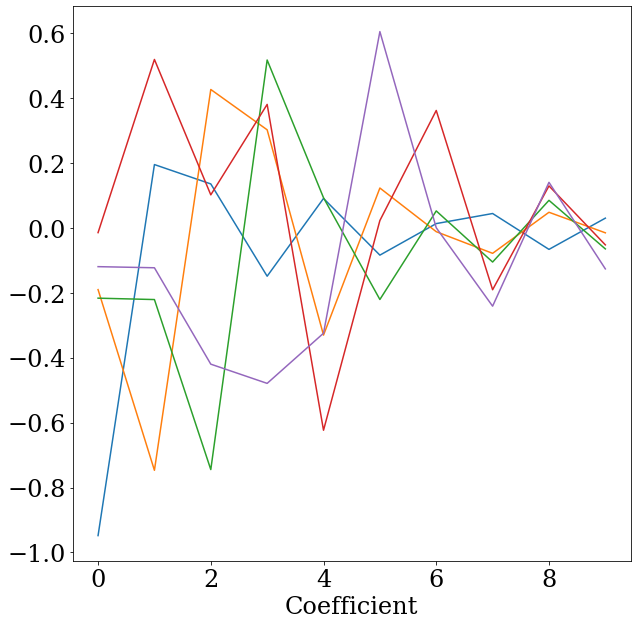

In [344]:
vals, vects = np.linalg.eig(fsh['n8yj02x0q.spectrum'])#+fsh['n8yj02wyq.spectrum'])

order = np.argsort(vals)[::-1]

plt.figure(figsize=(10,10))
plt.xlabel("Coefficient")

for i in range(5):
    plt.plot(np.arange(npoly),np.real(vects[:,order[i]]), label=f"{i}")
#plt.legend()

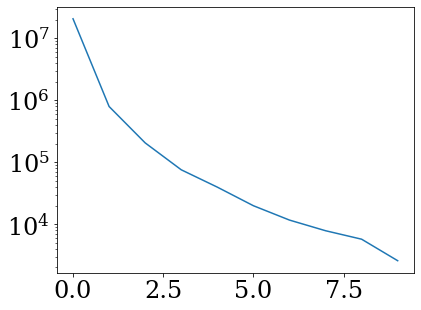

In [345]:
plt.semilogy(np.sort(np.real(vals))[::-1])

In [346]:
vals[order]

Array([2.0760774e+07+0.j, 7.9487181e+05+0.j, 2.0555973e+05+0.j,
       7.5558969e+04+0.j, 3.9652949e+04+0.j, 1.9866723e+04+0.j,
       1.1647562e+04+0.j, 7.8405669e+03+0.j, 5.7212778e+03+0.j,
       2.5709238e+03+0.j], dtype=complex64)

Text(0.5, 0, 'Wavelength (um)')

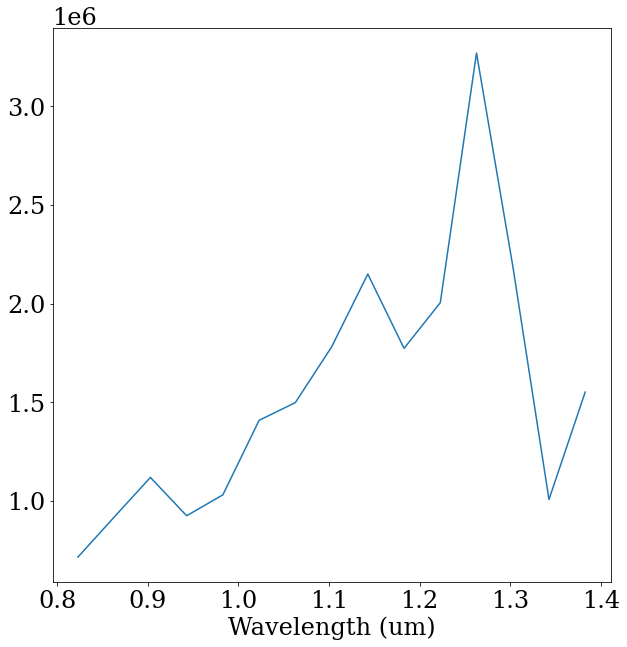

In [347]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=15)

spec = CombinedFourierSpectrum(wv, filt, final_params.get("spectrum.U11296_F110W"))

#HD201592_F110M

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv*1e6, spec.spec_weights()*spec.flux/(wv*1e6))#, yerr = spectrum_err)
plt.xlabel("Wavelength (um)")


In [348]:
symmetric_cov = spectrum_cov + spectrum_cov.T - np.diag(spectrum_cov.diagonal())

In [349]:
from jax.numpy import linalg as la
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [350]:
spec.wavelengths

Array([8.2298334e-07, 8.6295000e-07, 9.0291672e-07, 9.4288333e-07,
       9.8285000e-07, 1.0228167e-06, 1.0627833e-06, 1.1027500e-06,
       1.1427168e-06, 1.1826834e-06, 1.2226501e-06, 1.2626167e-06,
       1.3025834e-06, 1.3425501e-06, 1.3825168e-06], dtype=float32)

In [351]:
final_params.get("spectrum.U11296_F110W")

Array([ 2.50823   , -0.25932032, -0.10896785,  0.02689478, -0.01157766,
       -0.00479542,  0.02390755, -0.09228139,  0.06429745, -0.08974036],      dtype=float32)

In [352]:
wv[:-1]*1e6

Array([0.8229833, 0.86295  , 0.9029167, 0.9428833, 0.98285  , 1.0228168,
       1.0627834, 1.1027501, 1.1427168, 1.1826833, 1.22265  , 1.2626168,
       1.3025835, 1.3425502], dtype=float32)

In [353]:
s = spec.spec_weights()[:-1]
s/s.sum() /( wv[:-1]*1e9 /1e4)

Array([0.2909085 , 0.37317264, 0.4547987 , 0.3759222 , 0.41895786,
       0.5722828 , 0.60879713, 0.7232297 , 0.873276  , 0.72039896,
       0.81435317, 1.3280495 , 0.8903079 , 0.40943754], dtype=float32)

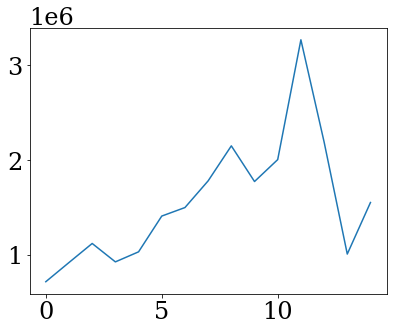

In [354]:
plt.plot(spec.spec_weights()*spec.flux/(wv*1e6))

Text(0, 0.5, 'Flux')

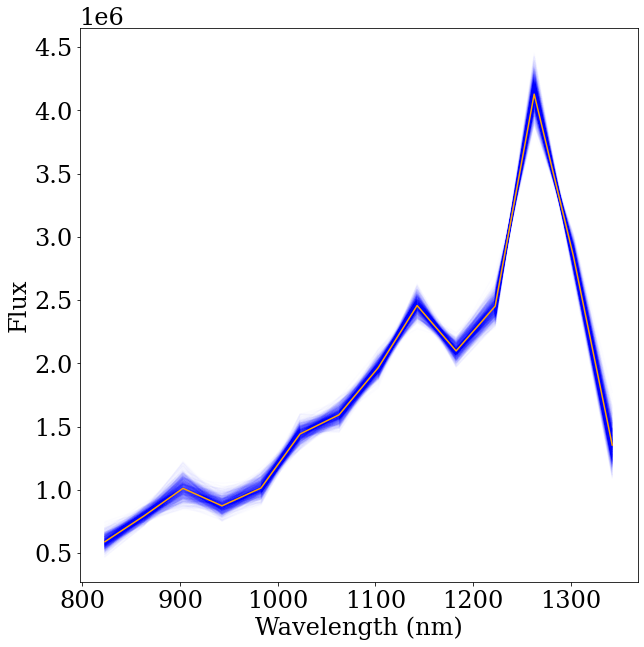

In [355]:
plt.figure(figsize=(10,10))

plt.plot(wv[:-1]*1e9, spec.spec_weights()[:-1]*spec.flux, color='orange')
for i in range(1000):
    coeffs = numpy.random.multivariate_normal(final_params.get("spectrum.U11296_F110W"), nearestPD(symmetric_cov))
    spec = CombinedFourierSpectrum(wv, filt, coeffs)
    plt.plot(wv[:-1]*1e9, spec.spec_weights()[:-1]*spec.flux, color='b', alpha=0.01, zorder=0)
    #plt.plot(wv*1e9, spec.spec_weights()*spec.flux, color='b', alpha=0.01, zorder=0)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux")


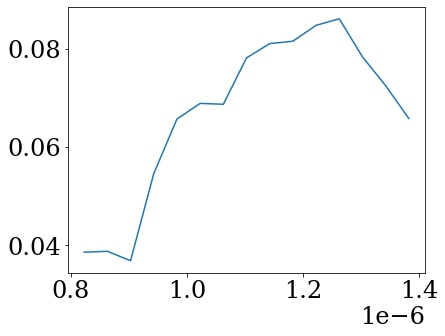

In [356]:
plt.plot(spec.wavelengths, spec.filt_weights)

In [357]:
bad = np.ones((wid, wid))

In [358]:
for i in range(8):
    pst = posterior(models[-1].inject(model_single),exposures_single[0],return_im=True)
    idx = np.unravel_index(np.nanargmax(pst*bad), pst.shape)
    bad = bad.at[idx].set(np.nan)


In [359]:
extra_bad = np.isnan(bad)

In [360]:
idx

(Array(40, dtype=int32), Array(38, dtype=int32))

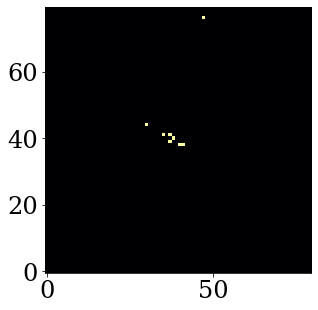

In [361]:
plt.imshow(extra_bad)

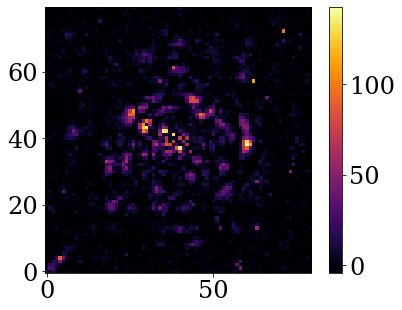

In [362]:
plt.imshow(pst*(1-extra_bad))
plt.colorbar()

In [363]:
jsp.stats.norm.logpdf(0,0,0.1)

Array(1.3836465, dtype=float32, weak_type=True)

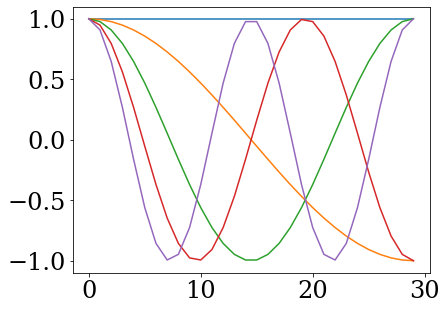

In [364]:
xs = np.linspace(0, 2*np.pi, 30)

for i,c in enumerate(np.ones(5)):
    plt.plot(np.cos(xs * i/2)*c)